# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [7]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


In [7]:
pip install matplotlib==3.10.0

Note: you may need to restart the kernel to use updated packages.


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [7]:
# Try loading one file

# df = pd.read_parquet('2023-1.parquet')
# df.info()
import os
#print(os.path.exists('trip_records/2023-1.parquet'))  # Shoul
df = pd.read_parquet('trip_records/2023-1.parquet')

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?
3041714
To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

print(f"Current directory: {os.getcwd()}")
# Select the folder having data files
os.chdir('trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()
df_res = pd.DataFrame()
samples = []

# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        df = pd.read_parquet(file_name)

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        #sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        df['datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['date'] = df['datetime'].dt.date
        df['hour'] = df['datetime'].dt.hour

        for date in df['date'].unique():
            daily_data = df[df['date'] == date]
            # Iterate through each hour of the selected date
            for hour in df['hour'].unique():
                 hour_data = daily_data[daily_data['hour'] == hour]
                # Sample 5% of the hourly data randomly
                 sample = hour_data.sample(frac=0.05, random_state=42)
                # add data of this hour to the dataframe
                 samples.append(sample)
        print(f"Completed processing {file_name}")
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

        # Concatenate the sampled data of all the dates to a single dataframe
        #df = # we initialised this empty DF earlier

Current directory: /Users/sweety/Documents/AI-ML-PGCourse/Assignments/Starter Notebook - EDA NYC Taxi
Completed processing 2023-12.parquet
Completed processing 2023-6.parquet
Completed processing 2023-7.parquet
Error processing .DS_Store: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Completed processing 2023-5.parquet
Completed processing 2023-11.parquet
Completed processing 2023-10.parquet
Completed processing 2023-4.parquet
Completed processing 2023-1.parquet
Completed processing 2023-8.parquet
Completed processing 2023-9.parquet
Completed processing 2023-2.parquet
Completed processing 2023-3.parquet


## After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [15]:
# Store the df in csv/parquet
# df.to_parquet('')
df_res = pd.concat(samples, ignore_index=True)
try:
    output_dir = '../trip_records'
    output_path = os.path.join(output_dir, 'updated_taxi_data.csv')
    df_res.to_csv(output_path, index=False)
    print(f"Successfully saved to: {os.path.abspath(output_path)}")
except PermissionError:
    print(f"Permission denied to write in {output_dir}")
except Exception as e:
    print(f"Save failed: {e}")

Successfully saved to: /Users/sweety/Documents/AI-ML-PGCourse/Assignments/Starter Notebook - EDA NYC Taxi/trip_records/updated_taxi_data.csv


## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [17]:
# Load the new data file
new_df = pd.read_csv('updated_taxi_data.csv')

In [19]:
new_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:38:48   2023-12-01 01:01:55              NaN   
2         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3         2  2023-12-01 00:00:50   2023-12-01 00:14:37              NaN   
4         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  N           148            50   
1           4.79         NaN                NaN           231            61   
2           1.05         1.0                  N           161           161   
3           2.08         NaN                NaN           137           144   
4           0.40         1.0                  N            68            68   

   payment_type  ...  tip_amount  tolls_amount  improvement_surcharge  \
0             1  ...        5.66           0.0                    1.0   
1             0  ...        3.00           0.0                    1.0   
2             1  ...        3.14           0.0                    1.0   
3             0  ...        0.00           0.0                    1.0   
4             1  ...        0.00           0.0                    1.0   

   total_amount  congestion_surcharge  Airport_fee             datetime  \
0         33.96                   2.5          0.0  2023-12-01 00:27:51   
1         29.43                   NaN          NaN  2023-12-01 00:38:48   
2         18.84                   2.5          0.0  2023-12-01 00:06:19   
3         21.22                   NaN          NaN  2023-12-01 00:00:50   
4         10.10                   2.5          0.0  2023-12-01 00:16:07   

         date  hour airport_fee  
0  2023-12-01     0         NaN  
1  2023-12-01     0         NaN  
2  2023-12-01     0         NaN  
3  2023-12-01     0         NaN  
4  2023-12-01     0         NaN  

[5 rows x 23 columns]

In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  Airport_fee            float64
 19  datetime               object 
 20  date                   object 
 21  hour                   int64  
 22  airport_fee       

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [23]:
# Fix the index and drop any columns that are not needed
new_df = new_df.reset_index(drop=True)
new_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:38:48   2023-12-01 01:01:55              NaN   
2         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3         2  2023-12-01 00:00:50   2023-12-01 00:14:37              NaN   
4         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  N           148            50   
1           4.79         NaN                NaN           231            61   
2           1.05         1.0                  N           161           161   
3           2.08         NaN                NaN           137           144   
4           0.40         1.0                  N            68            68   

   payment_type  ...  tip_amount  tolls_amount  improvement_surcharge  \
0             1  ...        5.66           0.0                    1.0   
1             0  ...        3.00           0.0                    1.0   
2             1  ...        3.14           0.0                    1.0   
3             0  ...        0.00           0.0                    1.0   
4             1  ...        0.00           0.0                    1.0   

   total_amount  congestion_surcharge  Airport_fee             datetime  \
0         33.96                   2.5          0.0  2023-12-01 00:27:51   
1         29.43                   NaN          NaN  2023-12-01 00:38:48   
2         18.84                   2.5          0.0  2023-12-01 00:06:19   
3         21.22                   NaN          NaN  2023-12-01 00:00:50   
4         10.10                   2.5          0.0  2023-12-01 00:16:07   

         date  hour airport_fee  
0  2023-12-01     0         NaN  
1  2023-12-01     0         NaN  
2  2023-12-01     0         NaN  
3  2023-12-01     0         NaN  
4  2023-12-01     0         NaN  

[5 rows x 23 columns]

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [25]:
# Combine the two airport fee columns
new_df['airport_fee'] = new_df['Airport_fee'].fillna(new_df['airport_fee'])
new_df = new_df.drop(columns=['Airport_fee'])
new_df.head()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  datetime               object 
 19  date                   object 
 20  hour                   int64  
 21  airport_fee            float64
dtypes: float64(12), in

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [27]:
# check where values of fare amount are negative
print(new_df['fare_amount'] < 0)
neg_fares = new_df[new_df['fare_amount'] < 0]

0          False
1          False
2          False
3          False
4          False
           ...  
1896395    False
1896396    False
1896397    False
1896398    False
1896399    False
Name: fare_amount, Length: 1896400, dtype: bool


Did you notice something different in the `RatecodeID` column for above records?

In [29]:
# Analyse RatecodeID for the negative fare amounts
negative_analysis = new_df[new_df['fare_amount'] < 0].groupby('RatecodeID')
print(negative_analysis.count())

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, datetime, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]


In [31]:
# Find which columns have negative values
print(negative_analysis.count().items)

<bound method DataFrame.items of Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, datetime, date, hour, airport_fee]
Index: []

[0 rows x 21 columns]>


In [37]:
# fix these negative values


Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, datetime, date, hour, airport_fee]
Index: []

[0 rows x 22 columns]

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [33]:
# Find the proportion of missing values in each column
new_df.isnull().mean()

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.034209
trip_distance            0.000000
RatecodeID               0.034209
store_and_fwd_flag       0.034209
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.034209
datetime                 0.000000
date                     0.000000
hour                     0.000000
airport_fee              0.034209
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [35]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
new_df[(new_df['passenger_count'].isnull())]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1               2  2023-12-01 00:38:48   2023-12-01 01:01:55              NaN   
3               2  2023-12-01 00:00:50   2023-12-01 00:14:37              NaN   
27              2  2023-12-01 00:01:11   2023-12-01 00:15:53              NaN   
122             2  2023-12-01 00:02:18   2023-12-01 00:12:25              NaN   
127             1  2023-12-01 00:04:14   2023-12-01 00:25:16              NaN   
...           ...                  ...                   ...              ...   
1896242         2  2023-06-30 19:05:12   2023-06-30 19:13:04              NaN   
1896253         2  2023-06-30 19:25:07   2023-06-30 19:55:28              NaN   
1896312         2  2023-06-30 19:21:00   2023-06-30 19:35:00              NaN   
1896383         6  2023-06-30 19:06:42   2023-06-30 20:06:53              NaN   
1896395         2  2023-06-30 19:38:51   2023-06-30 19:51:30              NaN   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1                 4.79         NaN                NaN           231   
3                 2.08         NaN                NaN           137   
27                3.49         NaN                NaN           164   
122               1.79         NaN                NaN           142   
127               0.00         NaN                NaN           186   
...                ...         ...                ...           ...   
1896242           1.28         NaN                NaN           141   
1896253           9.89         NaN                NaN            79   
1896312           1.93         NaN                NaN            50   
1896383          18.28         NaN                NaN           265   
1896395           2.23         NaN                NaN            48   

         DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
1                  61             0  ...      0.5        3.00           0.0   
3                 144             0  ...      0.5        0.00           0.0   
27                262             0  ...      0.5        0.00           0.0   
122               239             0  ...      0.5        0.00           0.0   
127                74             0  ...      0.5        0.00           0.0   
...               ...           ...  ...      ...         ...           ...   
1896242           229             0  ...      0.5        3.45           0.0   
1896253           244             0  ...      0.5        0.00           0.0   
1896312           234             0  ...      0.5        0.00           0.0   
1896383           101             0  ...      0.5        0.00           0.0   
1896395           249             0  ...      0.5        4.02           0.0   

         improvement_surcharge  total_amount  congestion_surcharge  \
1                          1.0         29.43                   NaN   
3                          1.0         21.22                   NaN   
27                         1.0         21.83                   NaN   
122                        1.0         13.88                   NaN   
127                        1.0         34.31                   NaN   
...                        ...           ...                   ...   
1896242                    1.0         20.69                   NaN   
1896253                    1.0         41.38                   NaN   
1896312                    1.0         19.21                   NaN   
1896383                    0.3         57.68                   NaN   
1896395                    1.0         24.12                   NaN   

                    datetime        date hour airport_fee  
1        2023-12-01 00:38:48  2023-12-01    0         NaN  
3        2023-12-01 00:00:50  2023-12-01    0         NaN  
27       2023-12-01 00:01:11  2023-12-01    0         NaN  
122      2023-12-01 00:02:18  2023-12-01    0         NaN  
127      2023-12-01 00:04:14  2023-12-01    0         NaN  
...                      ...     

In [37]:
new_df['passenger_count'] = new_df['passenger_count'].fillna(0.0)

In [39]:
new_df['airport_fee'] = new_df['airport_fee'].fillna(0.0)
new_df['airport_fee'] = new_df['airport_fee'].fillna(0.0)

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [41]:
# Fix missing values in 'RatecodeID'
new_df['RatecodeID'] = new_df['RatecodeID'].fillna(0.0)

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [43]:
# handle null values in congestion_surcharge
new_df['congestion_surcharge'] = new_df['congestion_surcharge'].fillna(0.0)
new_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:38:48   2023-12-01 01:01:55              0.0   
2         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3         2  2023-12-01 00:00:50   2023-12-01 00:14:37              0.0   
4         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  N           148            50   
1           4.79         0.0                NaN           231            61   
2           1.05         1.0                  N           161           161   
3           2.08         0.0                NaN           137           144   
4           0.40         1.0                  N            68            68   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             1  ...      0.5        5.66           0.0   
1             0  ...      0.5        3.00           0.0   
2             1  ...      0.5        3.14           0.0   
3             0  ...      0.5        0.00           0.0   
4             1  ...      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  \
0                    1.0         33.96                   2.5   
1                    1.0         29.43                   0.0   
2                    1.0         18.84                   2.5   
3                    1.0         21.22                   0.0   
4                    1.0         10.10                   2.5   

              datetime        date hour airport_fee  
0  2023-12-01 00:27:51  2023-12-01    0         0.0  
1  2023-12-01 00:38:48  2023-12-01    0         0.0  
2  2023-12-01 00:06:19  2023-12-01    0         0.0  
3  2023-12-01 00:00:50  2023-12-01    0         0.0  
4  2023-12-01 00:16:07  2023-12-01    0         0.0  

[5 rows x 22 columns]

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [45]:
# Handle any remaining missing values
new_df['store_and_fwd_flag'] = new_df['store_and_fwd_flag'].fillna('N')

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

             passenger_count  trip_distance    RatecodeID   fare_amount  \
count           1.896400e+06   1.896400e+06  1.896400e+06  1.896400e+06   
mean            1.322376e+00   3.858293e+00  1.578772e+00  1.991935e+01   
std             9.119691e-01   1.294085e+02  7.272418e+00  1.055371e+02   
min             0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
1%              0.000000e+00   0.000000e+00  0.000000e+00  4.400000e+00   
5%              1.000000e+00   4.600000e-01  1.000000e+00  5.800000e+00   
25%             1.000000e+00   1.050000e+00  1.000000e+00  9.300000e+00   
50%             1.000000e+00   1.790000e+00  1.000000e+00  1.350000e+01   
75%             1.000000e+00   3.400000e+00  1.000000e+00  2.190000e+01   
95%             3.000000e+00   1.529000e+01  2.000000e+00  7.000000e+01   
99%             5.000000e+00   2.022000e+01  5.000000e+00  7.720000e+01   
max             9.000000e+00   1.263605e+05  9.900000e+01  1.431635e+05   
IQR             0.000000e

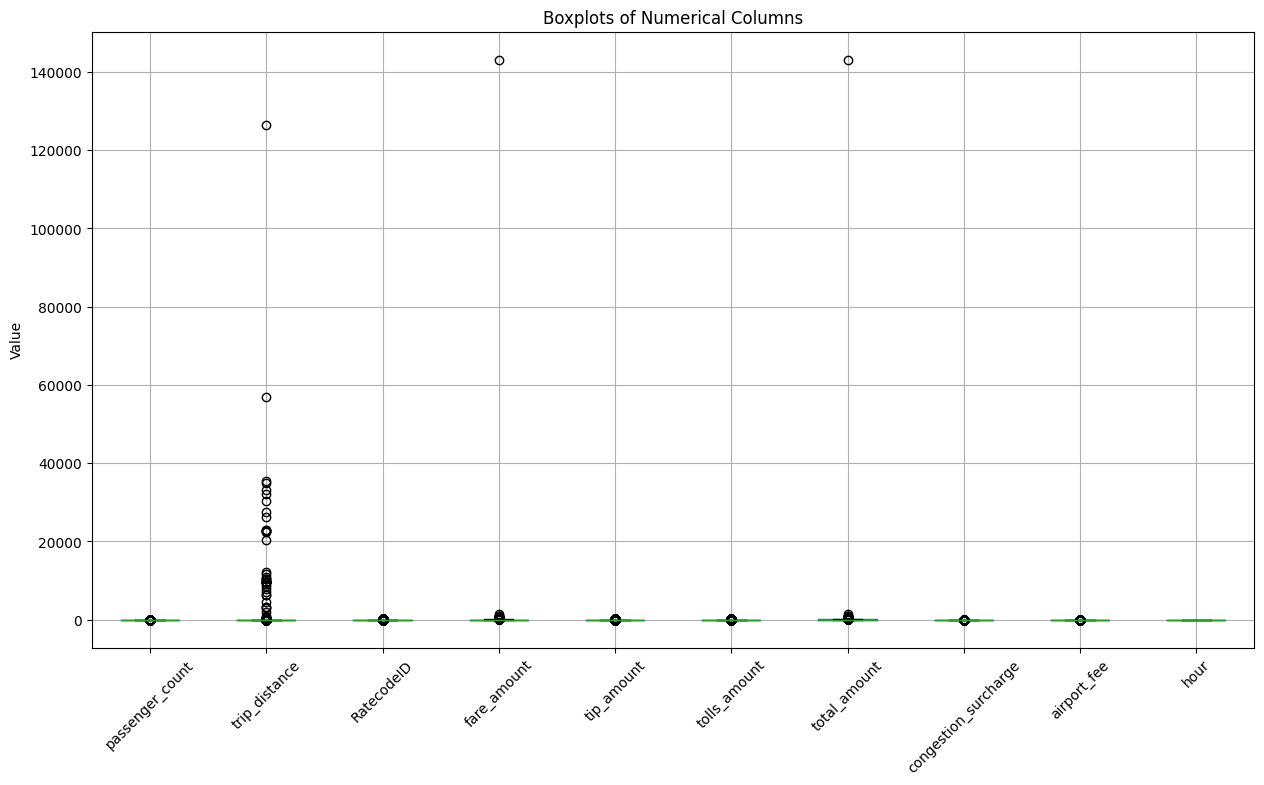

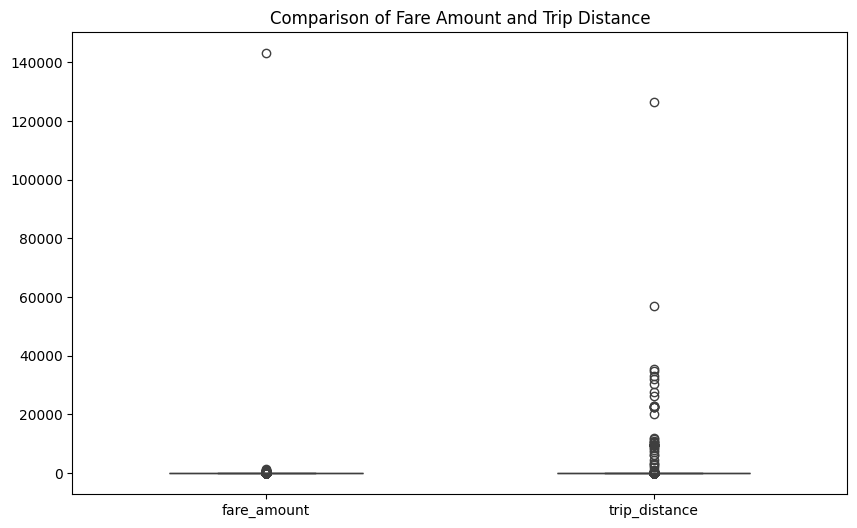

In [47]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

num_cols = ['passenger_count', 'trip_distance', 'RatecodeID', 'fare_amount',
            'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge',
            'airport_fee', 'hour']
outlier_report = new_df[num_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
for col in num_cols:
    Q1 = new_df[col].quantile(0.25)
    Q3 = new_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_report.loc['IQR', col] = IQR
    outlier_report.loc['Lower Bound', col] = Q1 - 1.5*IQR
    outlier_report.loc['Upper Bound', col] = Q3 + 1.5*IQR
print(outlier_report)

plt.figure(figsize=(15, 8))
new_df[num_cols].boxplot()
plt.xticks(rotation=45)
plt.title('Boxplots of Numerical Columns')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=new_df[['fare_amount', 'trip_distance']], width=0.5)
plt.title('Comparison of Fare Amount and Trip Distance')
plt.show()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [49]:
# remove passenger_count > 6
new_df[new_df['passenger_count']>6]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  datetime               object 
 19  date                   object 
 20  hour                   int64  
 21  airport_fee            float64
dtypes: float64(12), in

In [51]:
# Continue with outlier handling
new_df[(new_df['trip_distance'] < 0.0) & 
                  (new_df['fare_amount'] > 300)]
new_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:38:48   2023-12-01 01:01:55              0.0   
2         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3         2  2023-12-01 00:00:50   2023-12-01 00:14:37              0.0   
4         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  N           148            50   
1           4.79         0.0                  N           231            61   
2           1.05         1.0                  N           161           161   
3           2.08         0.0                  N           137           144   
4           0.40         1.0                  N            68            68   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             1  ...      0.5        5.66           0.0   
1             0  ...      0.5        3.00           0.0   
2             1  ...      0.5        3.14           0.0   
3             0  ...      0.5        0.00           0.0   
4             1  ...      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  \
0                    1.0         33.96                   2.5   
1                    1.0         29.43                   0.0   
2                    1.0         18.84                   2.5   
3                    1.0         21.22                   0.0   
4                    1.0         10.10                   2.5   

              datetime        date hour airport_fee  
0  2023-12-01 00:27:51  2023-12-01    0         0.0  
1  2023-12-01 00:38:48  2023-12-01    0         0.0  
2  2023-12-01 00:06:19  2023-12-01    0         0.0  
3  2023-12-01 00:00:50  2023-12-01    0         0.0  
4  2023-12-01 00:16:07  2023-12-01    0         0.0  

[5 rows x 22 columns]

In [53]:
# Do any columns need standardising?
invalid_trips=(
    (new_df['trip_distance'] == 0) & 
    (new_df['fare_amount'] == 0) & 
    (new_df['PULocationID'] != new_df['DOLocationID']
))

new_df1 = new_df[~(invalid_trips)]
new_df1 = new_df1[~(new_df1['trip_distance'] > 250)]
new_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1896291 entries, 0 to 1896399
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  datetime               object 
 19  date                   object 
 20  hour                   int64  
 21  airport_fee            float64
dtypes: float64(12), int64(5

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [55]:
#df.columns.tolist()
new_df1.columns.tolist()
new_df1.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:38:48   2023-12-01 01:01:55              0.0   
2         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3         2  2023-12-01 00:00:50   2023-12-01 00:14:37              0.0   
4         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  N           148            50   
1           4.79         0.0                  N           231            61   
2           1.05         1.0                  N           161           161   
3           2.08         0.0                  N           137           144   
4           0.40         1.0                  N            68            68   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             1  ...      0.5        5.66           0.0   
1             0  ...      0.5        3.00           0.0   
2             1  ...      0.5        3.14           0.0   
3             0  ...      0.5        0.00           0.0   
4             1  ...      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  \
0                    1.0         33.96                   2.5   
1                    1.0         29.43                   0.0   
2                    1.0         18.84                   2.5   
3                    1.0         21.22                   0.0   
4                    1.0         10.10                   2.5   

              datetime        date hour airport_fee  
0  2023-12-01 00:27:51  2023-12-01    0         0.0  
1  2023-12-01 00:38:48  2023-12-01    0         0.0  
2  2023-12-01 00:06:19  2023-12-01    0         0.0  
3  2023-12-01 00:00:50  2023-12-01    0         0.0  
4  2023-12-01 00:16:07  2023-12-01    0         0.0  

[5 rows x 22 columns]

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

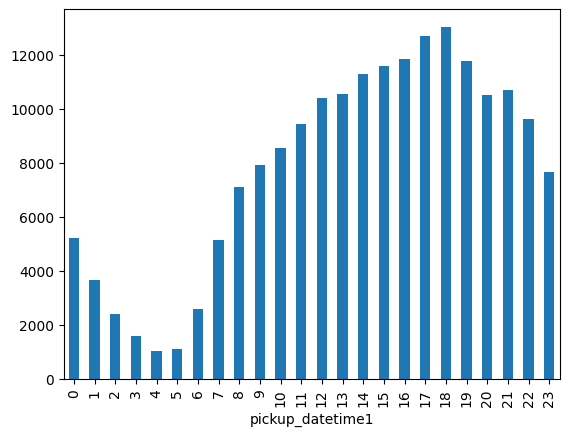

In [60]:
# Find and show the hourly trends in taxi pickups
df_sample = new_df1.sample(frac=0.1, random_state=42)
df_sample['pickup_datetime1'] = pd.to_datetime(df_sample['tpep_pickup_datetime'])
hourly = df_sample.groupby(df_sample['pickup_datetime1'].dt.hour).size()
hourly.plot(kind='bar')
plt.show()

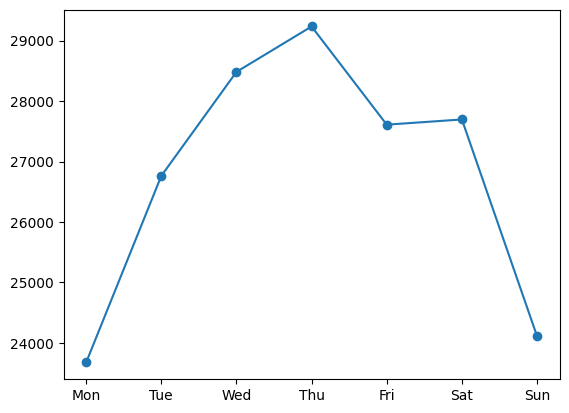

In [70]:
# Find and show the daily trends in taxi pickups (days of the week)
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily = df_sample.groupby(df_sample['pickup_datetime1'].dt.dayofweek).size()
daily.index = day_names
daily.plot(kind='line', marker='o')
plt.show()

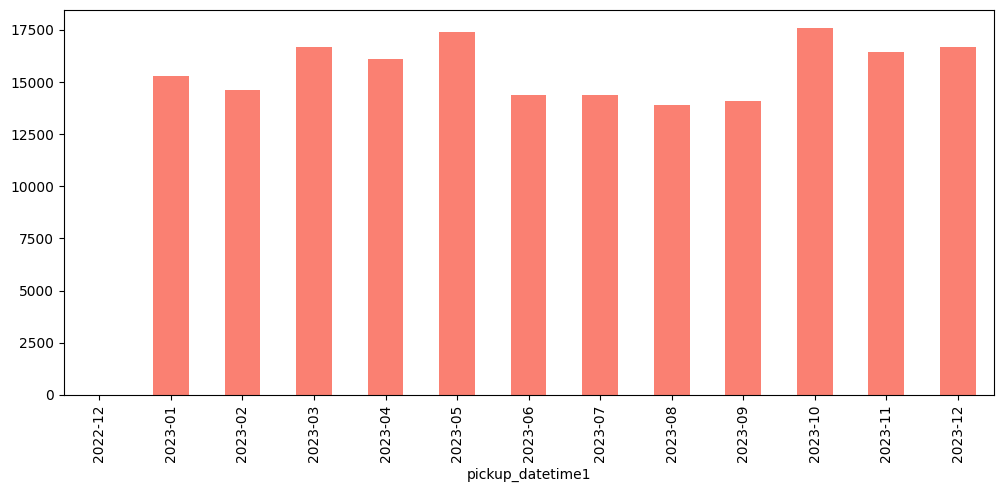

In [74]:
# Show the monthly trends in pickups
monthly = df_sample.groupby(df_sample['pickup_datetime1'].dt.to_period('M')).size()

# Plot
plt.figure(figsize=(12, 5))
monthly.plot(kind='bar', color='salmon')
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [57]:
# Analyse the above parameters
update1 = ((new_df1['trip_distance'] <= 0.0) & 
           (new_df1['total_amount'] <= 0.0) & (new_df1['tip_amount'] <= 0.0) & (new_df1['fare_amount'] <= 0.0))
new_df3 = new_df1[~update1]

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [59]:
# Create a df with non zero entries for the selected parameters.

epsilon = 1e-6  # Adjust based on your data precision
update2 = ((new_df3['trip_distance'].abs() > epsilon) & 
           (new_df3['total_amount'].abs() > epsilon) & (new_df3['tip_amount'].abs() > epsilon) & (new_df3['fare_amount'].abs() > epsilon))
new_df5 = new_df3[~update2]
new_df5.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3          2  2023-12-01 00:00:50   2023-12-01 00:14:37              0.0   
4          2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
7          2  2023-12-01 00:36:28   2023-12-01 00:36:34              1.0   
20         2  2023-12-01 00:18:11   2023-12-01 00:28:26              1.0   
21         2  2023-12-01 00:22:45   2023-12-01 00:31:27              1.0   

    trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
3            2.08         0.0                  N           137           144   
4            0.40         1.0                  N            68            68   
7            0.00         5.0                  N           170           170   
20           0.99         1.0                  N           264           264   
21           1.29         1.0                  N            79           231   

    payment_type  ...  mta_tax  tip_amount  tolls_amount  \
3              0  ...      0.5         0.0           0.0   
4              1  ...      0.5         0.0           0.0   
7              1  ...      0.0         2.9           0.0   
20             2  ...      0.5         0.0           0.0   
21             2  ...      0.5         0.0           0.0   

    improvement_surcharge  total_amount  congestion_surcharge  \
3                     1.0         21.22                   0.0   
4                     1.0         10.10                   2.5   
7                     1.0         17.40                   2.5   
20                    1.0         13.20                   0.0   
21                    1.0         15.00                   2.5   

               datetime        date hour airport_fee  
3   2023-12-01 00:00:50  2023-12-01    0         0.0  
4   2023-12-01 00:16:07  2023-12-01    0         0.0  
7   2023-12-01 00:36:28  2023-12-01    0         0.0  
20  2023-12-01 00:18:11  2023-12-01    0         0.0  
21  2023-12-01 00:22:45  2023-12-01    0         0.0  

[5 rows x 22 columns]

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [61]:
# Group data by month and analyse monthly revenue
new_df5['pickup_datetime2'] = pd.to_datetime(new_df5['tpep_pickup_datetime'])
monthly2 = new_df5.groupby(new_df5['pickup_datetime2'].dt.to_period('M'))['total_amount'].sum()
print(monthly2)
#mean_monthly_revenue = monthly_revenue.mean()

pickup_datetime2
2023-01     853464.13
2023-02     789951.58
2023-03     958402.61
2023-04     999870.14
2023-05    1052800.71
2023-06    1018101.71
2023-07     969893.40
2023-08     987301.93
2023-09    1093018.74
2023-10    1100727.30
2023-11     977566.92
2023-12    1124710.37
Freq: M, Name: total_amount, dtype: float64


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [188]:
# Calculate proportion of each quarter
monthly2.isnull().mean()

0.0

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

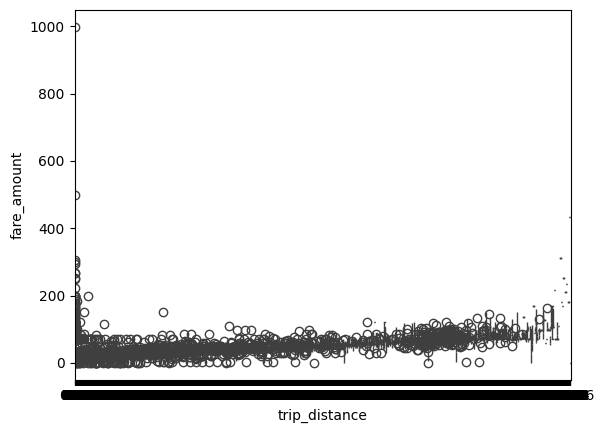

Pearson correlation coefficient: 0.079


In [201]:
# Show how trip fare is affected by distance
df_sample2 = new_df5.sample(frac=0.1, random_state=42)
#sns.boxplot(x='trip_distance', y='fare_amount', data=df_sample2, palette='Set2')
sns.boxplot(
    x='trip_distance',
    y='fare_amount',
    data=df_sample2  # Makes overlapping points visible
)
plt.show()

correlation = new_df5['trip_distance'].corr(new_df5['fare_amount'])
print(f"Pearson correlation coefficient: {correlation:.3f}")

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

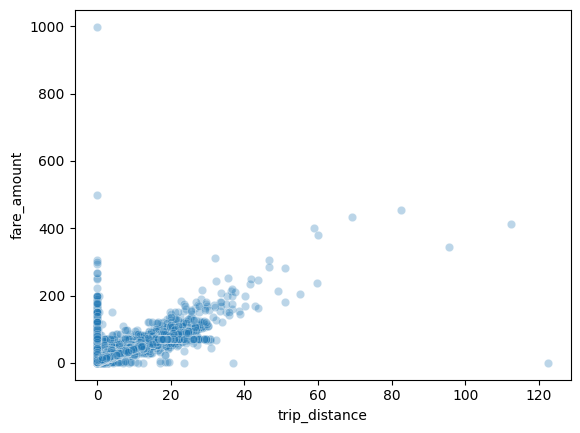

In [203]:
# Show relationship between fare and trip duration
sns.scatterplot(
    x='trip_distance',
    y='fare_amount',
    data=df_sample2,
    alpha=0.3  # Makes overlapping points visible
)
plt.show()

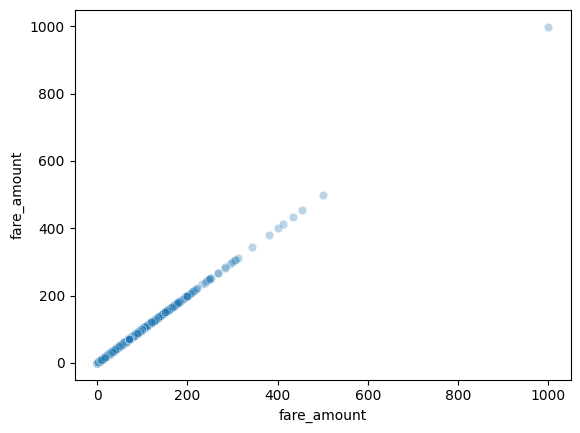

In [205]:
# Show relationship between fare and number of passengers
sns.scatterplot(
    x='fare_amount',
    y='fare_amount',
    data=df_sample2,
    alpha=0.3  # Makes overlapping points visible
)
plt.show()


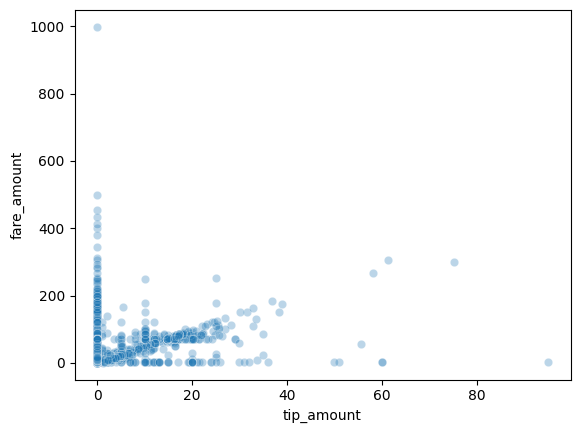

In [207]:
# Show relationship between tip and trip distance
sns.scatterplot(
    x='tip_amount',
    y='fare_amount',
    data=df_sample2,
    alpha=0.3  # Makes overlapping points visible
)
plt.show()


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

<Axes: xlabel='payment_type_name', ylabel='count'>

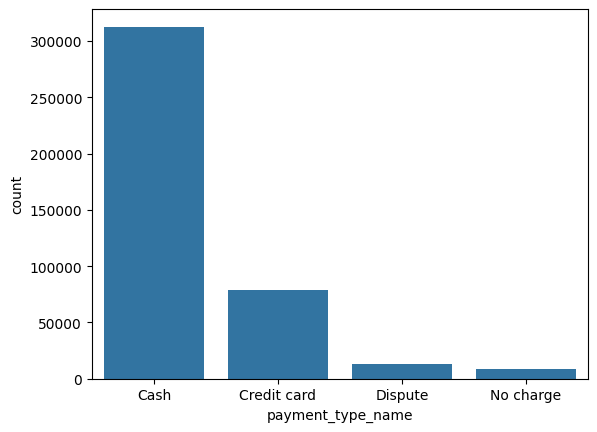

In [209]:
# Analyse the distribution of different payment types (payment_type).
payment_labels = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute'
}

# Convert numeric codes to categorical labels
new_df5['payment_type_name'] = new_df5['payment_type'].map(payment_labels)
sns.countplot(
    x='payment_type_name',
    data=new_df5,
    order=new_df5['payment_type_name'].value_counts().index
)


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [223]:
# !pip install geopandas
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 29.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.6 MB/s eta 0:00:00


**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [1]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file('taxi_zones/taxi_zones.shp') # read the .shp file using gpd
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'pandas.core.frame.DataFrame'>
Index: 444858 entries, 3 to 1896389
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               444858 non-null  int64         
 1   tpep_pickup_datetime   444858 non-null  object        
 2   tpep_dropoff_datetime  444858 non-null  object        
 3   passenger_count        444858 non-null  float64       
 4   trip_distance          444858 non-null  float64       
 5   RatecodeID             444858 non-null  float64       
 6   store_and_fwd_flag     444858 non-null  object        
 7   PULocationID           444858 non-null  int64         
 8   DOLocationID           444858 non-null  int64         
 9   payment_type           444858 non-null  int64         
 10  fare_amount            444858 non-null  float64       
 11  extra                  444858 non-null  float64       
 12  mta_tax                444858 non-null  float64 

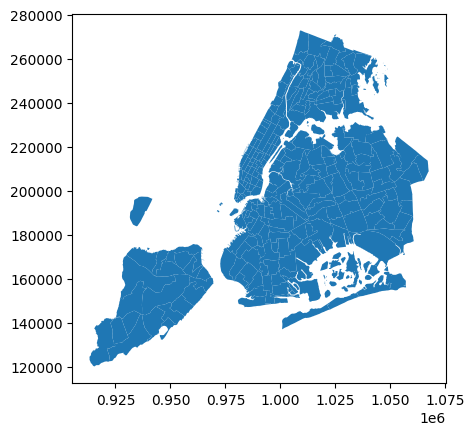

In [67]:
# print(zones.info())
# zones.plot()
zones.plot()
zones = zones.rename(columns={'LocationID': 'PULocationID'})
new_df5.info()
zones.info()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [73]:
# Merge zones and trip records using locationID and PULocationID
merged_data = new_df5.merge(
    zones, 
    on='PULocationID'
)
merged_data.head()
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438435 entries, 0 to 438434
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               438435 non-null  int64         
 1   tpep_pickup_datetime   438435 non-null  object        
 2   tpep_dropoff_datetime  438435 non-null  object        
 3   passenger_count        438435 non-null  float64       
 4   trip_distance          438435 non-null  float64       
 5   RatecodeID             438435 non-null  float64       
 6   store_and_fwd_flag     438435 non-null  object        
 7   PULocationID           438435 non-null  int64         
 8   DOLocationID           438435 non-null  int64         
 9   payment_type           438435 non-null  int64         
 10  fare_amount            438435 non-null  float64       
 11  extra                  438435 non-null  float64       
 12  mta_tax                438435 non-null  floa

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [133]:
# Group data by location and calculate the number of trips
#merged_data.groupby('PULocationID').size().count()
trip_counts = merged_data.groupby('PULocationID').size().reset_index(name='trips')
print(trip_counts)

     PULocationID  trips
0               1    181
1               3     44
2               4    661
3               5     13
4               6     24
..            ...    ...
247           259     51
248           260    267
249           261   2880
250           262   4908
251           263   7515

[252 rows x 2 columns]
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      263 non-null    int32   
 1   Shape_Leng    263 non-null    float64 
 2   Shape_Area    263 non-null    float64 
 3   zone          263 non-null    object  
 4   PULocationID  263 non-null    int32   
 5   borough       263 non-null    object  
 6   geometry      263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [135]:
# Merge trip counts back to the zones GeoDataFrame

merged_data12 = trip_counts.merge(
    merged_data, 
    on='PULocationID'
)

zones = trip_counts.merge(
    zones, 
    on='PULocationID'
)
merged_data12.info()
zones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438435 entries, 0 to 438434
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   PULocationID           438435 non-null  int64         
 1   trips                  438435 non-null  int64         
 2   VendorID               438435 non-null  int64         
 3   tpep_pickup_datetime   438435 non-null  object        
 4   tpep_dropoff_datetime  438435 non-null  object        
 5   passenger_count        438435 non-null  float64       
 6   trip_distance          438435 non-null  float64       
 7   RatecodeID             438435 non-null  float64       
 8   store_and_fwd_flag     438435 non-null  object        
 9   DOLocationID           438435 non-null  int64         
 10  payment_type           438435 non-null  int64         
 11  fare_amount            438435 non-null  float64       
 12  extra                  438435 non-null  floa

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

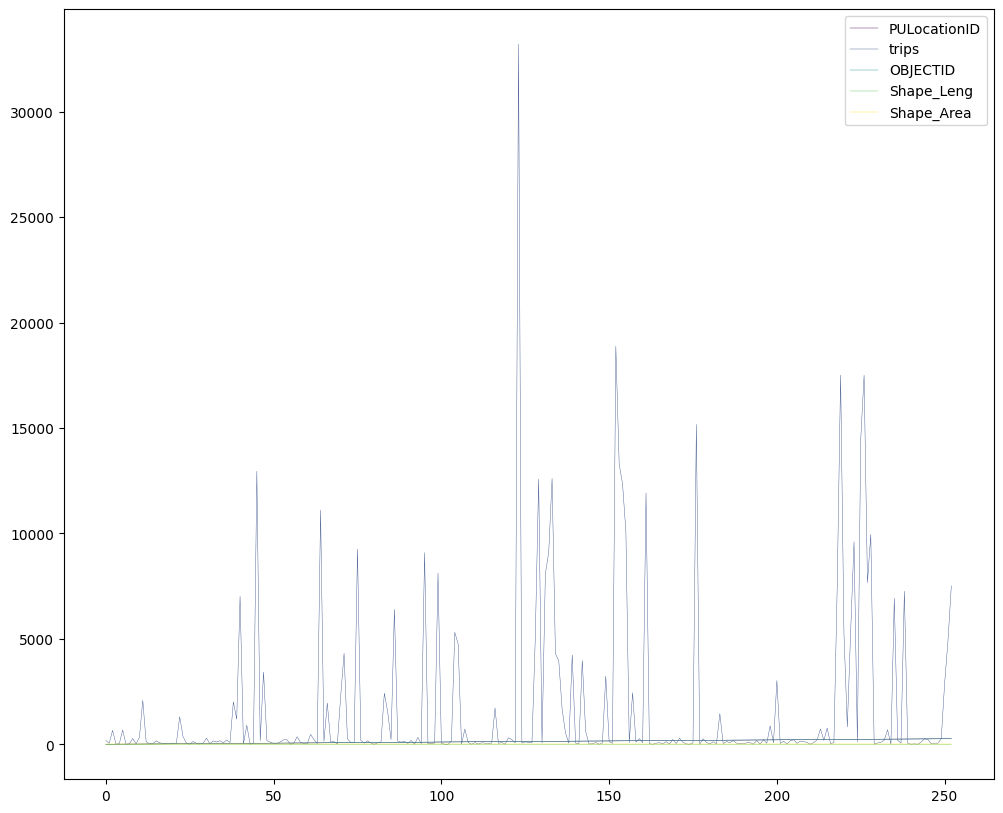

In [145]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
zones.plot(
    column='trips',  # Column containing values to visualize
    ax=ax,                     # Use the axis we created
    legend=True,               # Show color legend
    cmap='viridis',       # Border color (optional)
    linewidth=0.3             # Border thickness (optional)
)

# Plot the map and display it
plt.show()


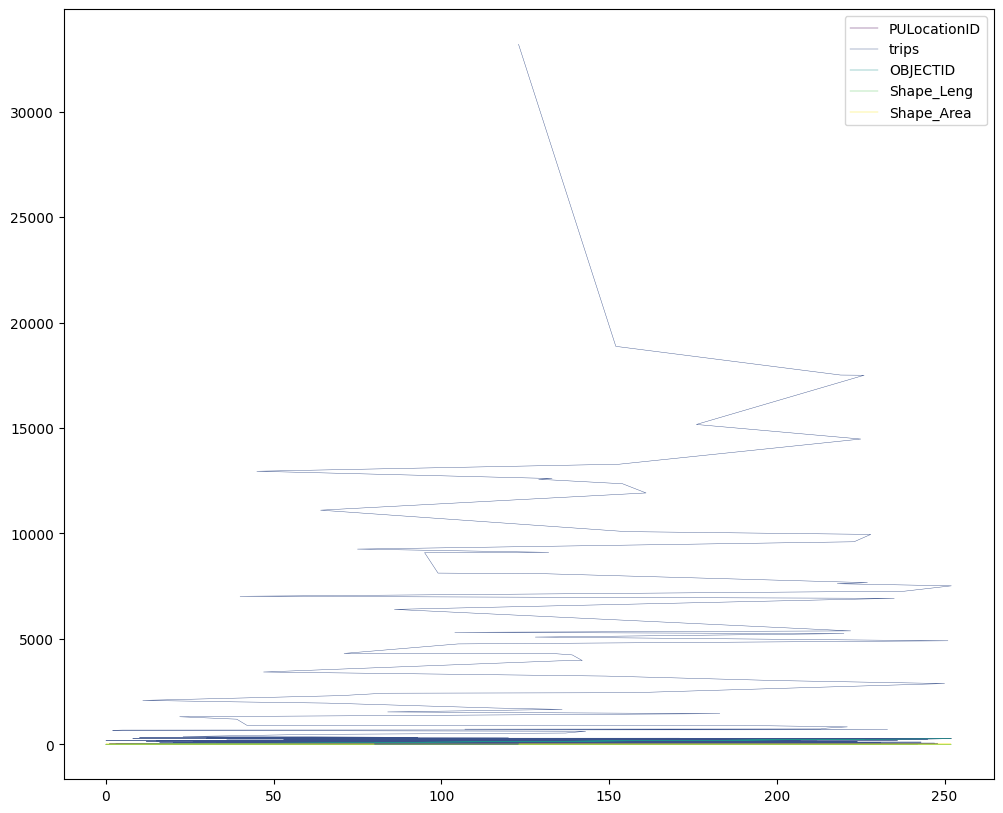

In [147]:
# can you try displaying the zones DF sorted by the number of trips?
soreted_zones = zones.sort_values('trips', ascending=False)
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
soreted_zones.plot(
    column='trips',  # Column containing values to visualize
    ax=ax,                     # Use the axis we created
    legend=True,               # Show color legend
    cmap='viridis',       # Border color (optional)
    linewidth=0.3             # Border thickness (optional)
)

# Plot the map and display it
plt.show()



Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438435 entries, 0 to 438434
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   VendorID               438435 non-null  int64          
 1   tpep_pickup_datetime   438435 non-null  object         
 2   tpep_dropoff_datetime  438435 non-null  object         
 3   passenger_count        438435 non-null  float64        
 4   trip_distance          438435 non-null  float64        
 5   RatecodeID             438435 non-null  float64        
 6   store_and_fwd_flag     438435 non-null  object         
 7   PULocationID           438435 non-null  int64          
 8   DOLocationID           438435 non-null  int64          
 9   payment_type           438435 non-null  int64          
 10  fare_amount            438435 non-null  float64        
 11  extra                  438435 non-null  float64        
 12  mta_tax                438435 

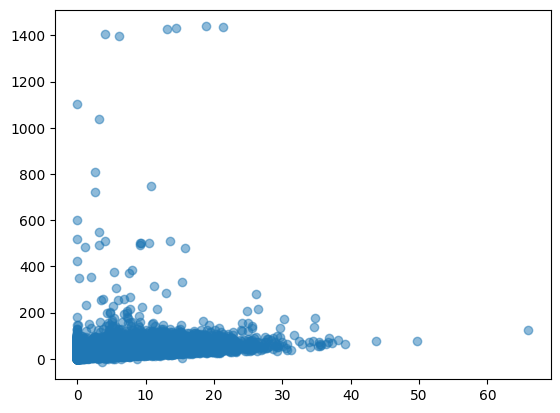

In [163]:
# Find routes which have the slowest speeds at different times of the day
merged_data.info()
merged_data['pickup_time'] = pd.to_datetime(merged_data['tpep_pickup_datetime'])
merged_data['drop_time'] = pd.to_datetime(merged_data['tpep_dropoff_datetime'])

merged_data['trip_duration'] = merged_data['drop_time'] - merged_data['pickup_time']

merged_data['trip_in_minutes'] = merged_data['trip_duration'].dt.total_seconds() / 60

merged_data['speed_mph'] = merged_data['trip_distance'] / (merged_data['trip_in_minutes'] / 60)

slow_routes = merged_data.groupby(['PULocationID', 'DOLocationID']).agg({
    'speed_mph': 'mean',
    'trip_distance': 'mean',
    'trip_in_minutes': 'mean',
    'VendorID': 'count'
}).sort_values(['speed_mph']).reset_index()

#distance_groups = merged_data.groupby('trip_distance').agg({
#    'trip_in_minutes': 'mean',  # Average duration per distance
#    'VendorID': 'count'         # Number of trips per distance
#}).sort_index(ascending=True).reset_index()

slow_routes.head()

plt.scatter(slow_routes['trip_distance'], slow_routes['trip_in_minutes'], alpha=0.5)
plt.show()

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [165]:
# Visualise the number of trips per hour and find the busiest hour
trip_per_hour = merged_data.groupby('hour').size().reset_index(name='trips')
#trip_counts = merged_data.groupby('PULocationID').size().reset_index(name='trips')
print(trip_per_hour)

    hour  trips
0      0  12318
1      1   8405
2      2   5935
3      3   4444
4      4   3763
5      5   3801
6      6   7386
7      7  11865
8      8  15166
9      9  18580
10    10  22339
11    11  24481
12    12  26494
13    13  27769
14    14  29043
15    15  29346
16    16  28314
17    17  28001
18    18  27696
19    19  24493
20    20  21389
21    21  20781
22    22  19554
23    23  17072


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [173]:
# Scale up the number of trips
#merged_data.info()

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = merged_data.sample(frac=0.2, random_state=42)

merged_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:00:50   2023-12-01 00:14:37              0.0   
1         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
2         2  2023-12-01 00:36:28   2023-12-01 00:36:34              1.0   
3         2  2023-12-01 00:22:45   2023-12-01 00:31:27              1.0   
4         1  2023-12-01 00:00:47   2023-12-01 00:01:59              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.08         0.0                  N           137           144   
1           0.40         1.0                  N            68            68   
2           0.00         5.0                  N           170           170   
3           1.29         1.0                  N            79           231   
4           0.20         1.0                  N           238           238   

   payment_type  ...  Shape_Leng  Shape_Area                   zone  \
0             0  ...    0.046108    0.000116               Kips Bay   
1             1  ...    0.049337    0.000111           East Chelsea   
2             1  ...    0.045769    0.000074            Murray Hill   
3             2  ...    0.042625    0.000108           East Village   
4             4  ...    0.060109    0.000185  Upper West Side North   

     borough                                           geometry  \
0  Manhattan  POLYGON ((991954.728 209026.462, 991949.076 20...   
1  Manhattan  POLYGON ((983690.405 209040.369, 983550.612 20...   
2  Manhattan  POLYGON ((991999.299 210994.739, 991972.635 21...   
3  Manhattan  POLYGON ((988746.067 202151.955, 988733.885 20...   
4  Manhattan  POLYGON ((992877.88 225627.534, 992741.735 225...   

          pickup_time           drop_time   trip_duration trip_in_minutes  \
0 2023-12-01 00:00:50 2023-12-01 00:14:37 0 days 00:13:47       13.783333   
1 2023-12-01 00:16:07 2023-12-01 00:19:17 0 days 00:03:10        3.166667   
2 2023-12-01 00:36:28 2023-12-01 00:36:34 0 days 00:00:06        0.100000   
3 2023-12-01 00:22:45 2023-12-01 00:31:27 0 days 00:08:42        8.700000   
4 2023-12-01 00:00:47 2023-12-01 00:01:59 0 days 00:01:12        1.200000   

   speed_mph  
0   9.054414  
1   7.578947  
2   0.000000  
3   8.896552  
4  10.000000  

[5 rows x 34 columns]

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 24 to 47
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_weekend       24 non-null     bool   
 1   hour             24 non-null     int32  
 2   VendorID         24 non-null     int64  
 3   trip_distance    24 non-null     float64
 4   speed_mph        24 non-null     float64
 5   trip_in_minutes  24 non-null     float64
dtypes: bool(1), float64(3), int32(1), int64(1)
memory usage: 1.1 KB


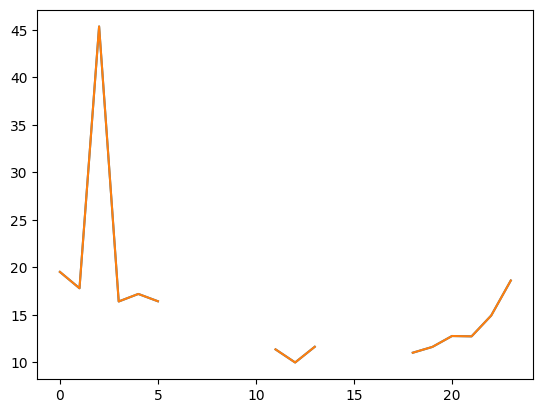

In [207]:
# Compare traffic trends for the week days and weekends
merged_data['dayofweek'] = pd.to_datetime(merged_data['tpep_pickup_datetime'])
merged_data['weekday'] = merged_data['dayofweek'].dt.day_name()
merged_data['is_weekend'] = merged_data['dayofweek'].dt.dayofweek >= 5
merged_data['hour'] = merged_data['dayofweek'].dt.hour

hourly_trends = merged_data.groupby(['is_weekend', 'hour']).agg({
    'VendorID': 'count',          # Number of trips
    'trip_distance': 'mean',      # Average distance
    'speed_mph': 'mean',
    'trip_in_minutes': 'mean'   # Average duration
}).reset_index()

weekday_data = hourly_trends[~hourly_trends['is_weekend']]
weekend_data = hourly_trends[hourly_trends['is_weekend']]
weekend_data.info()
plt.plot(weekday_data['hour'], weekday_data['speed_mph'], label='Weekdays')

plt.plot(weekday_data['hour'], weekday_data['speed_mph'], label='Weekends')


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [203]:
# Find top 10 pickup and dropoff zones
top_pick_zones = merged_data.groupby('zone').size().reset_index(name='PULocationID')
top_pick_zones.head(10)
top_drop_zones = merged_data.groupby('zone').size().reset_index(name='DOLocationID')
top_drop_zones.head(10)

zone  DOLocationID
0  Allerton/Pelham Gardens            44
1            Alphabet City           661
2            Arden Heights            13
3  Arrochar/Fort Wadsworth            24
4                  Astoria           673
5             Astoria Park             4
6               Auburndale            21
7             Baisley Park           274
8               Bath Beach            27
9             Battery Park           325

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [217]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
locations = merged_data.groupby('PULocationID').agg(
    pickups=('PULocationID', 'count')
).join(
    merged_data.groupby('DOLocationID').agg(
        dropoffs=('DOLocationID', 'count')
    ),
    how='outer'
).fillna(0)

locations['pickup_dropoff_ratio'] = locations['pickups'] / (locations['dropoffs'] + 1)  # +1 to avoid division by zero

top_10 = locations.nlargest(10, 'pickup_dropoff_ratio')

bottom_10 = locations.nsmallest(10, 'pickup_dropoff_ratio')


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [223]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
#merged_data[(merged_data['hour'] >= 23) & (merged_data['hour'] < 5)]


night_hrs = merged_data[((merged_data['hour'] >= 23) | (merged_data['hour'] < 5))]

# Get top 10 pickup zones during night hours
top_pickup_zones = night_hrs['PULocationID'].value_counts().nlargest(10).reset_index()
print(top_dropoff_zones)
top_pickup_zones.columns = ['LocationID', 'NightPickups']

# Get top 10 dropoff zones during night hours
top_dropoff_zones = night_hrs['DOLocationID'].value_counts().nlargest(10).reset_index()
print(top_dropoff_zones)
top_dropoff_zones.columns = ['LocationID', 'NightDropoffs']


   LocationID  NightDropoffs
0          48           1844
1          79           1777
2         230           1608
3          68           1413
4         170           1314
5         164           1163
6         186           1162
7         148           1059
8         107            973
9         249            906
   DOLocationID  count
0            48   1844
1            79   1777
2           230   1608
3            68   1413
4           170   1314
5           164   1163
6           186   1162
7           148   1059
8           107    973
9           249    906


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [225]:
# Filter for night hours (11 PM to 5 AM)
print(night_hrs)

        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0              2  2023-12-01 00:00:50   2023-12-01 00:14:37              0.0   
1              2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
2              2  2023-12-01 00:36:28   2023-12-01 00:36:34              1.0   
3              2  2023-12-01 00:22:45   2023-12-01 00:31:27              1.0   
4              1  2023-12-01 00:00:47   2023-12-01 00:01:59              1.0   
...          ...                  ...                   ...              ...   
437653         1  2023-06-30 04:26:59   2023-06-30 04:42:52              0.0   
437654         1  2023-06-30 04:48:37   2023-06-30 05:04:46              1.0   
437655         2  2023-06-30 04:45:38   2023-06-30 05:02:44              1.0   
437656         2  2023-06-30 04:12:33   2023-06-30 04:16:27              0.0   
437657         2  2023-06-30 04:45:16   2023-06-30 04:55:32              1.0   

        trip_distance  RatecodeID store

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [243]:
# Analyse the fare per mile per passenger for different passenger counts

merged_data['fare_per_mile_per_passenger'] = merged_data['fare_amount'] / (merged_data['trip_distance'] * merged_data['passenger_count']).replace(0, 1)
fare_analysis = merged_data.groupby('passenger_count').agg({
    'fare_per_mile_per_passenger': ['mean', 'median', 'std'],
    'trip_distance': 'mean',
    'fare_amount': 'mean',
    'VendorID': 'count'
}).reset_index()

print(fare_analysis)


  passenger_count fare_per_mile_per_passenger                         \
                                         mean     median         std   
0             0.0                   20.747489  17.660000   13.480231   
1             1.0                   17.951847   7.328767  425.523484   
2             2.0                   11.948130   3.625000  132.565706   
3             3.0                    6.599938   2.440945   63.452011   
4             4.0                    7.765614   1.844512   64.803723   
5             5.0                    2.624718   1.471861   14.086213   
6             6.0                    1.774767   1.233850    5.214968   
7             7.0                   39.402679  38.478474   44.041544   
8             8.0                   86.500000  86.500000    1.290994   
9             9.0                  110.343915  95.000000   31.007514   

  trip_distance fare_amount VendorID  
           mean        mean    count  
0      1.978092   20.747489    33988  
1      3.362727   

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [231]:
# Compare the average fare per mile for different days and for different times of the day
avgfare_amount = merged_data['fare_amount'].mean()
merged_data.groupby(merged_data['hour']).size().reset_index(name=avgfare_amount)
merged_data.groupby(merged_data['dayofweek']).size().reset_index(name=avgfare_amount)


dayofweek  21.281637
0      2023-01-01 00:04:42          1
1      2023-01-01 00:05:51          1
2      2023-01-01 00:06:59          1
3      2023-01-01 00:07:12          1
4      2023-01-01 00:07:18          1
...                    ...        ...
434382 2023-12-31 23:44:04          1
434383 2023-12-31 23:48:25          1
434384 2023-12-31 23:51:50          1
434385 2023-12-31 23:54:03          1
434386 2023-12-31 23:57:51          1

[434387 rows x 2 columns]

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [249]:
# Compare fare per mile for different vendors
merged_data.info()

merged_data['fare_per_mile'] = merged_data['fare_amount'] / merged_data['trip_distance'].replace(0, float('nan'))

# Group by vendor and calculate statistics
vendor_fare= merged_data.groupby('VendorID').agg({
    'fare_per_mile': ['mean', 'median', 'std', 'count'],
    'trip_distance': 'mean',
    'fare_amount': 'mean',
    'trip_in_minutes': 'mean'
}).reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438435 entries, 0 to 438434
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype          
---  ------                       --------------   -----          
 0   VendorID                     438435 non-null  int64          
 1   tpep_pickup_datetime         438435 non-null  object         
 2   tpep_dropoff_datetime        438435 non-null  object         
 3   passenger_count              438435 non-null  float64        
 4   trip_distance                438435 non-null  float64        
 5   RatecodeID                   438435 non-null  float64        
 6   store_and_fwd_flag           438435 non-null  object         
 7   PULocationID                 438435 non-null  int64          
 8   DOLocationID                 438435 non-null  int64          
 9   payment_type                 438435 non-null  int64          
 10  fare_amount                  438435 non-null  float64        
 11  extra        

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [255]:
# Defining distance tiers

merged_data['dist_tier'] = pd.cut(merged_data['trip_distance'],
                                    bins=[0, 2, 5, float('inf')],
                                    labels=['0-2 miles', '2-5 miles', '5+ miles'])

# Calculate fare per mile (handle zero distances)
merged_data['fare_per_mile'] = merged_data['fare_amount'] / merged_data['trip_distance'].replace(0, 1)

# Group by vendor and distance tier
vendor_tier_analysis = merged_data.groupby(['VendorID', 'dist_tier']).agg({
    'fare_per_mile': ['mean', 'std', 'count'],
    'fare_amount': 'mean',
    'trip_distance': 'mean'
}).reset_index()

print(vendor_tier_analysis)

  VendorID  dist_tier fare_per_mile                     fare_amount  \
                               mean         std   count        mean   
0        1  0-2 miles     14.378238  802.802236   64934   12.329241   
1        1  2-5 miles      6.445615    1.846408   26406   19.493583   
2        1   5+ miles      4.300078    0.984047   22238   48.464048   
3        2  0-2 miles     32.943161  338.076384  160394   10.445073   
4        2  2-5 miles      6.562465    1.834376   71042   19.517961   
5        2   5+ miles      4.495575    1.002384   58187   51.906273   

  trip_distance  
           mean  
0      1.093002  
1      3.093589  
2     11.813940  
3      1.087794  
4      3.041889  
5     12.037651  


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [267]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
merged_data['tip_pct'] = (merged_data['tip_amount'] / merged_data['total_amount'] * 100);

distance_tip = merged_data.groupby('dist_tier').agg(
    avg_tip_pct=('tip_pct', 'mean'),
    median_tip_pct=('tip_pct', 'median'),
    trip_count=('tip_pct', 'count')
).reset_index()

print(distance_tip)

passenger_tip = merged_data.groupby('passenger_count').agg(
    avg_tip_pct=('tip_pct', 'mean'),
    median_tip_pct=('tip_pct', 'median'),
    trip_count=('tip_pct', 'count')
).reset_index()

print(passenger_tip)

merged_data['pickup_period'] = pd.cut(merged_data['hour'],
                                     bins=[0, 6, 10, 16, 20, 24],
                                     labels=['Late Night', 'Morning', 'Midday', 'Evening', 'Night'])
                                      
# 3. By Time of Day
time_tip = merged_data.groupby('pickup_period').agg(
    avg_tip_pct=('tip_pct', 'mean'),
    median_tip_pct=('tip_pct', 'median'),
    trip_count=('tip_pct', 'count')
).reset_index()
print(time_tip)

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [305]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
#tip_info = (merged_data[([merged_data['tip_pct'] < 10) & (merged_data['tip_pct'] > 25))

#merged_data.head(10)

tip_info = merged_data[(merged_data['tip_pct'] == 0.0) | (merged_data['tip_pct'] > 0.25)]

print(tip_info.head())
#merged_data.groupby('trips').size().reset_index(name=tip_info)

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:00:50   2023-12-01 00:14:37              0.0   
1         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
2         2  2023-12-01 00:36:28   2023-12-01 00:36:34              1.0   
3         2  2023-12-01 00:22:45   2023-12-01 00:31:27              1.0   
4         1  2023-12-01 00:00:47   2023-12-01 00:01:59              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.08         0.0                  N           137           144   
1           0.40         1.0                  N            68            68   
2           0.00         5.0                  N           170           170   
3           1.29         1.0                  N            79           231   
4           0.20         1.0                  N           238           238   

   payment_type  ...  speed_mph           dayofweek  weekday  is_weekend  

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [ ]:
# See how passenger count varies across hours and days

merged_data['day_name'] = merged_data['dayofweek'].dt.day_name()

# Group by hour and day
hour_day_analysis = merged_data.groupby(['hour', 'day_name']).agg(
    avg_passengers=('passenger_count', 'mean'),
    trip_count=('passenger_count', 'count')
).reset_index()

# Pivot for heatmap with proper day ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = hour_day_analysis.pivot(index='day_name', columns='hour', values='avg_passengers').reindex(day_order)

# Create visualization
plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    linewidths=.5,
    cmap='YlOrRd',
    cbar_kws={'label': 'Average Passenger Count'}
)

hour_day_analysis = merged_data.groupby(['hour', 'dayofweek']).agg(
    avg_passengers=('passenger_count', 'mean'),
    trip_count=('passenger_count', 'count')
).reset_index()

# Pivot for heatmap
heatmap_data = hour_day_analysis.pivot(index='dayofweek', columns='hour', values='avg_passengers')

# Create ordered categorical days
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#heatmap_data = heatmap_data.reindex(days_order)

# Create visualization
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    linewidths=.5,
)
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [323]:
# How does passenger count vary across zones
mean_pct = merged_data['passenger_count'].mean()
passenget_cnt_zones = merged_data.groupby('zone').agg(mean_passenger_count=('passenger_count', 'mean'),
    trip_count=('passenger_count', 'size')
).reset_index()


                        zone  mean_passenger_count  trip_count
0    Allerton/Pelham Gardens              0.931818          44
1              Alphabet City              0.939486         661
2              Arden Heights              1.000000          13
3    Arrochar/Fort Wadsworth              1.750000          24
4                    Astoria              1.099554         673
..                       ...                   ...         ...
247       Woodlawn/Wakefield              1.019608          51
248                 Woodside              1.198502         267
249       World Trade Center              1.555903        2880
250           Yorkville East              1.131622        4908
251           Yorkville West              1.209448        7515

[252 rows x 3 columns]


In [325]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
print(passenget_cnt_zones)

                        zone  mean_passenger_count  trip_count
0    Allerton/Pelham Gardens              0.931818          44
1              Alphabet City              0.939486         661
2              Arden Heights              1.000000          13
3    Arrochar/Fort Wadsworth              1.750000          24
4                    Astoria              1.099554         673
..                       ...                   ...         ...
247       Woodlawn/Wakefield              1.019608          51
248                 Woodside              1.198502         267
249       World Trade Center              1.555903        2880
250           Yorkville East              1.131622        4908
251           Yorkville West              1.209448        7515

[252 rows x 3 columns]


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [331]:
# How often is each surcharge applied?

surcharge_counts = merged_data[['improvement_surcharge', 'congestion_surcharge']].apply(lambda x: (x > 0).sum())

# Calculate percentage of trips with each surcharge
total_trips = len(merged_data)
surcharge_percentages = (surcharge_counts / total_trips) * 100
print(surcharge_percentages)

improvement_surcharge    99.85950
congestion_surcharge     78.84293
dtype: float64


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
Focus on peak hours (7-9 AM, 5-7 PM).
Avoid in congested routes.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [ ]:
Night shifts: Deploy more cabs in nightlife areas

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [ ]:
Increase fares during peak demand (dynamic pricing).
Offer discounts for long-distance trips.